In [4]:
# importing sys
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
import pandas as pd
import numpy as np
import allel
import itertools

### Fst

#### Load data

In [5]:
sample_set = "1244-VO-GH-YAWSON-VMF00149"
chroms = ['2L', '2R', '3L', '3R', 'X']

In [6]:
# Read metadata 
metadata = pd.read_csv("../../config/metadata.tsv", sep="\t")

chroms = ['2L', '2R', '3R', '3L', 'X']
snps = {}
pos = {}

for chrom in chroms:
    # Load Arrays
    snps[chrom], pos[chrom] = probe.loadZarrArrays(genotypePath=f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{chrom}/calldata/GT", 
                                             positionsPath=f"../../resources/snp_genotypes/all/sites/{chrom}/variants/POS/",
                                             siteFilterPath=None)

## Calculate Fst, location v location - coluzzii

In [7]:
chrom = '3L'
metadata.species_gambiae_coluzzii.value_counts()

coluzzii    422
gambiae      63
Name: species_gambiae_coluzzii, dtype: int64

In [8]:
cohorts = probe.getCohorts(metadata, columns=['location', 'species_gambiae_coluzzii'], minPopSize=4)
cohorts.head(4)

,location,species_gambiae_coluzzii,indices,cohortText,cohortNoSpaceText,colour
0,Adansi Apagya,coluzzii,"[63, 64, 65, 66, 67, 68, 69, 70, 238, 239, 240...",Adansi Apagya | coluzzii,AdansiApagya.coluzzii,#e41a1c
1,Adansi-Krom,coluzzii,"[20, 21, 22, 178, 372, 373]",Adansi-Krom | coluzzii,Adansi-Krom.coluzzii,#e41a1c
2,Adumanu,coluzzii,"[1, 146, 147, 148, 149]",Adumanu | coluzzii,Adumanu.coluzzii,#e41a1c
3,Ankaako,coluzzii,"[23, 24, 25, 26, 179, 180, 181, 182, 374, 375,...",Ankaako | coluzzii,Ankaako.coluzzii,#377eb8


An.coluzzii Fst location v location

In [8]:
loc_ac = {}

for idx, cohort in cohorts.iterrows():
    

    loc_ac[cohort['cohortText']] = snps[chrom].take(cohort['indices'], axis=1).count_alleles()

fst_list = []
x_list = []
y_list = []

for x,y in itertools.combinations(loc_ac.keys(), 2):
    x_list.append(x)
    y_list.append(y)

    fst, se, _, _ = allel.average_hudson_fst(loc_ac[x], loc_ac[y], blen=1000000)        
    fst_list.append(fst)
    
df= pd.DataFrame({'location1':x_list, 'location2': y_list, 'fst': fst_list})

KeyboardInterrupt: 

In [125]:
bool_ = np.logical_or(df['location1'].str.contains('gambiae'), df['location2'].str.contains('gambiae'))
df = df.query("~@bool_")
fst = df.pivot('location1', 'location2', 'fst')
fst.to_csv("../../results/fst_all_samples.tsv", sep="\t")

### Subsampling to 10 individuals and running 100 replicates

This was run on neptune (fst_resampling.py).

In [44]:
fst = pd.read_csv("../../results/Fst_replicates.tsv", sep="\t", index_col=[0,1])

In [40]:
fst = fst.groupby(['location1','location2']).agg('median').reset_index()

In [41]:
bool_ = np.logical_or(fst['location1'].str.contains('gambiae'), fst['location2'].str.contains('gambiae'))
fst = fst.query("~@bool_")
fst = fst.pivot('location1', 'location2', 'fst')

array([[<AxesSubplot:title={'center':'fst'}>]], dtype=object)

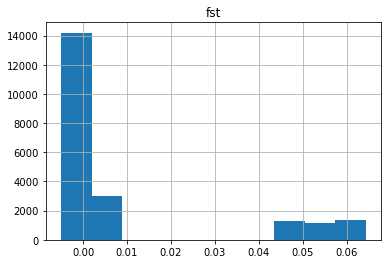

In [46]:
fst[['fst']].hist()

In [49]:
fst.query("fst > 0.05")

location1               location2       fst  replicate
0  5    Adansi Apagya | coluzzii      Asonkore | gambiae  0.059643          0
   12   Adansi Apagya | coluzzii  New Edubiase | gambiae  0.050188          0
   24     Adansi-Krom | coluzzii      Asonkore | gambiae  0.057861          0
   42         Adumanu | coluzzii      Asonkore | gambiae  0.058408          0
   59         Ankaako | coluzzii      Asonkore | gambiae  0.058429          0
...                          ...                     ...       ...        ...
99 184    New Edubiase | gambiae     Pokukrom | coluzzii  0.055356         99
   185    New Edubiase | gambiae  Prisintease | coluzzii  0.052497         99
   186    New Edubiase | gambiae       Wamase | coluzzii  0.052539         99
   187    New Edubiase | gambiae      Watreso | coluzzii  0.050728         99
   188    New Edubiase | gambiae       Yadome | coluzzii  0.051774         99

[2648 rows x 4 columns]

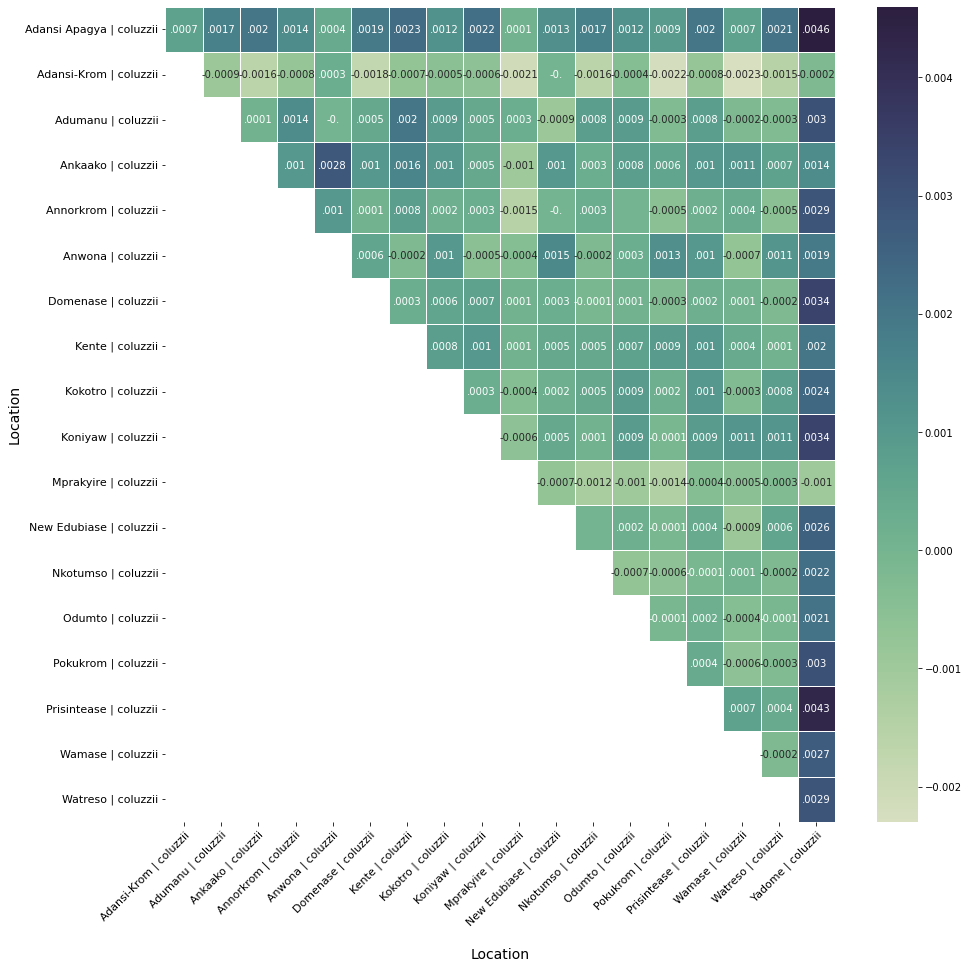

In [42]:
probe.plotRectangular(fst.round(4), path="../../results/fst_100_000.png", ylab="Location", xlab="Location", figsize=[15,15])

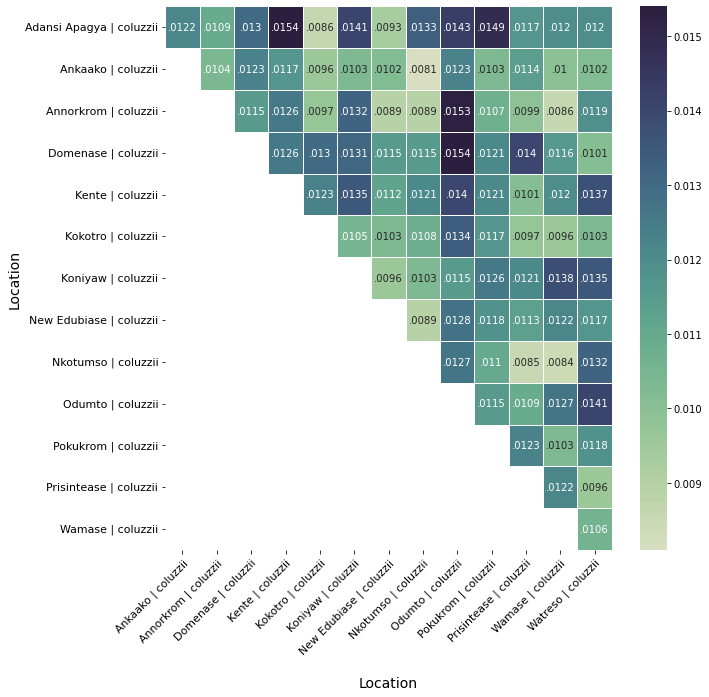

In [28]:
bool_ = np.logical_or(df['location1'].str.contains('gambiae'), df['location2'].str.contains('gambiae'))
df = df.query("~@bool_")
fst = df.pivot('location1', 'location2', 'fst')
probe.plotRectangular(fst.round(4), path="../../results/fst_100_000.png", ylab="Location", xlab="Location")


In [5]:
fst = pd.read_csv("../../results/fst.tsv", sep="\t").set_index("location1")
plotRectangular(fst.round(4), path=None, ylab="Location", xlab="Location")